In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from tensorflow.keras import activations
import matplotlib.pyplot as plt

import numpy as np
import time

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, Flatten


In [2]:
df = pd.read_csv("data/allWinter_delhi.csv")
df['From Date'] = df['Datetime']

df = df[['From Date','O3','Temperature','SO2','PM10','NO2','CO']] # new features : 6
df = df.replace(to_replace='None', value=np.nan)
df = df.dropna(axis = 0, how = 'all')
df['SO2'].fillna(df['SO2'].median(), inplace=True)

df = df.set_index('From Date')
df = df.iloc[::3, :]
df.to_csv('data1.csv')
print(df.columns)

print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum())

Index(['O3', 'Temperature', 'SO2', 'PM10', 'NO2', 'CO'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 O3             0
Temperature    0
SO2            0
PM10           0
NO2            0
CO             0
dtype: int64


In [3]:
# print(df)
dataset = read_csv('data1.csv', index_col=0)
dataset.columns = ['O3','Temperature','SO2','PM10','NO2','CO']
dataset.index.name = 'From Date'
# dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution1.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                        O3  Temperature   SO2    PM10    NO2     CO
From Date                                                          
2015-01-04 1:00:00   36.40         53.6  4.50  392.30  54.18  14.54
2015-01-04 4:00:00   26.23         51.8  4.28  246.69  33.62  17.77
2015-01-04 7:00:00   20.08         53.6  5.62  207.29  36.99  10.77
2015-01-04 10:00:00  15.00         57.2  5.66  118.18  33.56  10.45
2015-01-04 13:00:00  25.02         62.6  5.75  176.21  32.14   8.98
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


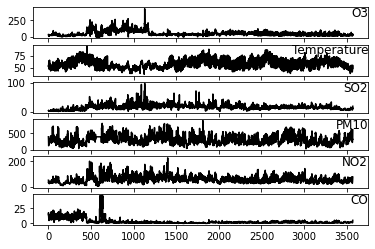

In [4]:
import pandas as pd
from matplotlib import pyplot

dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 4, 5]

i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
# ensure all data is float
values = dataset.values
values = values.astype('float32')
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
n_hours = 8
n_features = 6 # changed features from 5 to six
reframed = series_to_supervised(scaled, n_hours, 8)
print(reframed.shape)

(3558, 96)


(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 129s - loss: 0.9251 - val_loss: 0.2102
Epoch 2/25
42/42 - 13s - loss: 0.8277 - val_loss: 0.1556
Epoch 3/25
42/42 - 13s - loss: 0.5685 - val_loss: 0.1398
Epoch 4/25
42/42 - 13s - loss: 0.4923 - val_loss: 0.1260
Epoch 5/25
42/42 - 12s - loss: 0.4781 - val_loss: 0.1206
Epoch 6/25
42/42 - 12s - loss: 0.4888 - val_loss: 0.1120
Epoch 7/25
42/42 - 12s - loss: 0.4654 - val_loss: 0.1039
Epoch 8/25
42/42 - 12s - loss: 0.4421 - val_loss: 0.0989
Epoch 9/25
42/42 - 14s - loss: 0.4388 - val_loss: 0.0942
Epoch 10/25
42/42 - 13s - loss: 0.4496 - val_loss: 0.0977
Epoch 11/25
42/42 - 14s - loss: 0.4329 - val_loss: 0.0996
Epoch 12/25
42/42 - 14s - loss: 0.4287 - val_loss: 0.1007
Epoch 13/25
42/42 - 17s - loss: 0.4283 - val_loss: 0.0872
Epoch 14/25
42/42 - 20s - loss: 0.4099 - val_loss: 0.1065
Epoch 15/25
42/42 - 18s - loss: 0.4485 - val_loss: 0.0900
Epoch 16/25
42/42 - 14s - loss: 0.4358 - val_loss: 0.0755
Epoch

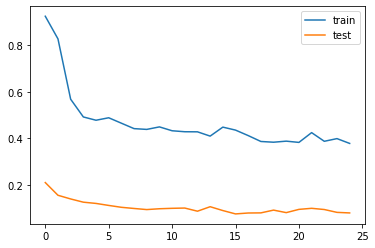

done | time taken: 542.586122 seconds
Test RMSE: 11.109
9.014218
0.5490227545951344
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 156s - loss: 0.7418 - val_loss: 0.2246
Epoch 2/25
42/42 - 10s - loss: 0.7935 - val_loss: 0.1671
Epoch 3/25
42/42 - 9s - loss: 0.6040 - val_loss: 0.1308
Epoch 4/25
42/42 - 9s - loss: 0.5349 - val_loss: 0.1351
Epoch 5/25
42/42 - 8s - loss: 0.5510 - val_loss: 0.1189
Epoch 6/25
42/42 - 8s - loss: 0.4653 - val_loss: 0.1076
Epoch 7/25
42/42 - 9s - loss: 0.4448 - val_loss: 0.1032
Epoch 8/25
42/42 - 9s - loss: 0.4442 - val_loss: 0.0987
Epoch 9/25
42/42 - 9s - loss: 0.4298 - val_loss: 0.0943
Epoch 10/25
42/42 - 9s - loss: 0.4201 - val_loss: 0.0973
Epoch 11/25
42/42 - 9s - loss: 0.4205 - val_loss: 0.1050
Epoch 12/25
42/42 - 11s - loss: 0.4252 - val_loss: 0.1011
Epoch 13/25
42/42 - 10s - loss: 0.4048 - val_loss: 0.0843
Epoch 14/25
42/42 - 13s - loss: 0.4276 - val_loss: 0.0975
Epoch 15/25
42/42 - 17s - loss: 0.4065 - val_l

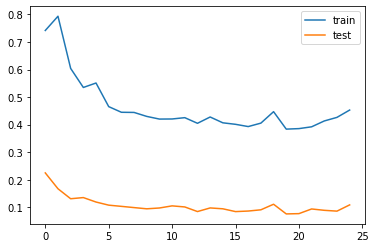

done | time taken: 500.870942 seconds
Test RMSE: 12.961
10.64647
0.38613134682204786
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 201s - loss: 0.6906 - val_loss: 0.2095
Epoch 2/25
42/42 - 17s - loss: 0.7816 - val_loss: 0.1620
Epoch 3/25
42/42 - 18s - loss: 0.6046 - val_loss: 0.1322
Epoch 4/25
42/42 - 14s - loss: 0.5596 - val_loss: 0.1289
Epoch 5/25
42/42 - 15s - loss: 0.5382 - val_loss: 0.1142
Epoch 6/25
42/42 - 13s - loss: 0.4633 - val_loss: 0.1086
Epoch 7/25
42/42 - 14s - loss: 0.4443 - val_loss: 0.0991
Epoch 8/25
42/42 - 13s - loss: 0.4538 - val_loss: 0.0943
Epoch 9/25
42/42 - 15s - loss: 0.4411 - val_loss: 0.0938
Epoch 10/25
42/42 - 14s - loss: 0.4320 - val_loss: 0.0862
Epoch 11/25
42/42 - 18s - loss: 0.4112 - val_loss: 0.0962
Epoch 12/25
42/42 - 12s - loss: 0.4054 - val_loss: 0.0887
Epoch 13/25
42/42 - 12s - loss: 0.4229 - val_loss: 0.1073
Epoch 14/25
42/42 - 15s - loss: 0.4177 - val_loss: 0.0945
Epoch 15/25
42/42 - 15s - loss: 0.43

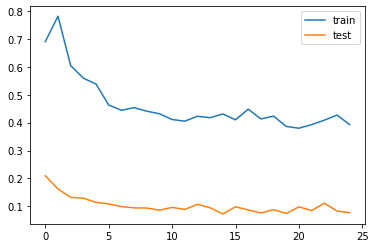

done | time taken: 632.388484 seconds
Test RMSE: 10.921
8.735173
0.5641806480631608
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 218s - loss: 0.8949 - val_loss: 0.2206
Epoch 2/25
42/42 - 18s - loss: 0.8166 - val_loss: 0.1578
Epoch 3/25
42/42 - 16s - loss: 0.5680 - val_loss: 0.1394
Epoch 4/25
42/42 - 14s - loss: 0.5054 - val_loss: 0.1307
Epoch 5/25
42/42 - 16s - loss: 0.4831 - val_loss: 0.1193
Epoch 6/25
42/42 - 18s - loss: 0.4678 - val_loss: 0.1108
Epoch 7/25
42/42 - 14s - loss: 0.4646 - val_loss: 0.1042
Epoch 8/25
42/42 - 16s - loss: 0.4593 - val_loss: 0.0987
Epoch 9/25
42/42 - 15s - loss: 0.4679 - val_loss: 0.0947
Epoch 10/25
42/42 - 18s - loss: 0.4207 - val_loss: 0.0934
Epoch 11/25
42/42 - 19s - loss: 0.4338 - val_loss: 0.0953
Epoch 12/25
42/42 - 15s - loss: 0.4196 - val_loss: 0.0843
Epoch 13/25
42/42 - 18s - loss: 0.4096 - val_loss: 0.0894
Epoch 14/25
42/42 - 17s - loss: 0.4198 - val_loss: 0.1084
Epoch 15/25
42/42 - 19s - loss: 0.483

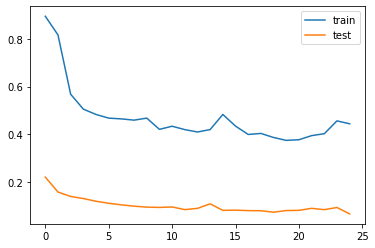

done | time taken: 688.895795 seconds
Test RMSE: 10.121
7.7336993
0.6256761335059708
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 67s - loss: 0.7774 - val_loss: 0.2214
Epoch 2/25
42/42 - 10s - loss: 0.8052 - val_loss: 0.1750
Epoch 3/25
42/42 - 9s - loss: 0.6258 - val_loss: 0.1314
Epoch 4/25
42/42 - 9s - loss: 0.5168 - val_loss: 0.1276
Epoch 5/25
42/42 - 8s - loss: 0.5104 - val_loss: 0.1130
Epoch 6/25
42/42 - 8s - loss: 0.4667 - val_loss: 0.1040
Epoch 7/25
42/42 - 8s - loss: 0.4435 - val_loss: 0.1014
Epoch 8/25
42/42 - 12s - loss: 0.4489 - val_loss: 0.1007
Epoch 9/25
42/42 - 8s - loss: 0.4555 - val_loss: 0.0935
Epoch 10/25
42/42 - 14s - loss: 0.4459 - val_loss: 0.0887
Epoch 11/25
42/42 - 13s - loss: 0.4222 - val_loss: 0.0919
Epoch 12/25
42/42 - 12s - loss: 0.4160 - val_loss: 0.1006
Epoch 13/25
42/42 - 12s - loss: 0.4611 - val_loss: 0.0959
Epoch 14/25
42/42 - 13s - loss: 0.4210 - val_loss: 0.0780
Epoch 15/25
42/42 - 15s - loss: 0.4340 - va

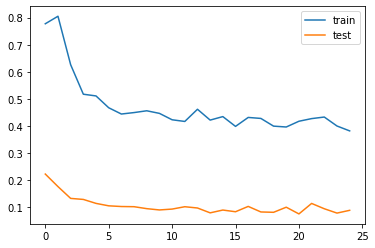

done | time taken: 351.068077 seconds
Test RMSE: 11.623
9.400844
0.5063389224676383
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 76s - loss: 0.9232 - val_loss: 0.2175
Epoch 2/25
42/42 - 10s - loss: 0.8230 - val_loss: 0.1544
Epoch 3/25
42/42 - 11s - loss: 0.5636 - val_loss: 0.1368
Epoch 4/25
42/42 - 9s - loss: 0.4901 - val_loss: 0.1274
Epoch 5/25
42/42 - 9s - loss: 0.4762 - val_loss: 0.1169
Epoch 6/25
42/42 - 8s - loss: 0.4768 - val_loss: 0.1118
Epoch 7/25
42/42 - 9s - loss: 0.4769 - val_loss: 0.1034
Epoch 8/25
42/42 - 12s - loss: 0.4575 - val_loss: 0.0985
Epoch 9/25
42/42 - 11s - loss: 0.4452 - val_loss: 0.0976
Epoch 10/25
42/42 - 11s - loss: 0.4375 - val_loss: 0.0937
Epoch 11/25
42/42 - 12s - loss: 0.4399 - val_loss: 0.0982
Epoch 12/25
42/42 - 14s - loss: 0.4175 - val_loss: 0.0877
Epoch 13/25
42/42 - 14s - loss: 0.4143 - val_loss: 0.0965
Epoch 14/25
42/42 - 13s - loss: 0.4155 - val_loss: 0.0953
Epoch 15/25
42/42 - 14s - loss: 0.4122 - v

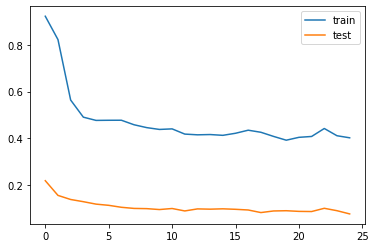

done | time taken: 392.017766 seconds
Test RMSE: 10.769
8.365229
0.5762336250699724
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 92s - loss: 0.7305 - val_loss: 0.2210
Epoch 2/25
42/42 - 13s - loss: 0.8116 - val_loss: 0.1693
Epoch 3/25
42/42 - 11s - loss: 0.6395 - val_loss: 0.1340
Epoch 4/25
42/42 - 11s - loss: 0.5382 - val_loss: 0.1288
Epoch 5/25
42/42 - 12s - loss: 0.5275 - val_loss: 0.1160
Epoch 6/25
42/42 - 9s - loss: 0.4629 - val_loss: 0.1064
Epoch 7/25
42/42 - 10s - loss: 0.4372 - val_loss: 0.0967
Epoch 8/25
42/42 - 12s - loss: 0.4400 - val_loss: 0.0981
Epoch 9/25
42/42 - 11s - loss: 0.4316 - val_loss: 0.0968
Epoch 10/25
42/42 - 10s - loss: 0.4242 - val_loss: 0.0879
Epoch 11/25
42/42 - 11s - loss: 0.4172 - val_loss: 0.0898
Epoch 12/25
42/42 - 21s - loss: 0.4285 - val_loss: 0.1049
Epoch 13/25
42/42 - 13s - loss: 0.4383 - val_loss: 0.0862
Epoch 14/25
42/42 - 16s - loss: 0.3978 - val_loss: 0.0789
Epoch 15/25
42/42 - 23s - loss: 0.4008 

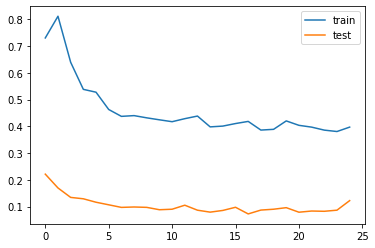

done | time taken: 500.539741 seconds
Test RMSE: 13.740
11.456536
0.3100954495344279
(3558, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (558, 8, 6) (558,)
Epoch 1/25
42/42 - 147s - loss: 0.9407 - val_loss: 0.2135
Epoch 2/25
42/42 - 8s - loss: 0.7694 - val_loss: 0.1533
Epoch 3/25
42/42 - 7s - loss: 0.5506 - val_loss: 0.1422
Epoch 4/25
42/42 - 8s - loss: 0.5433 - val_loss: 0.1297
Epoch 5/25
42/42 - 7s - loss: 0.4885 - val_loss: 0.1216
Epoch 6/25
42/42 - 8s - loss: 0.4854 - val_loss: 0.1093
Epoch 7/25
42/42 - 8s - loss: 0.4684 - val_loss: 0.1102
Epoch 8/25
42/42 - 8s - loss: 0.4730 - val_loss: 0.0967
Epoch 9/25
42/42 - 8s - loss: 0.4455 - val_loss: 0.0971
Epoch 10/25
42/42 - 9s - loss: 0.4445 - val_loss: 0.0888
Epoch 11/25
42/42 - 11s - loss: 0.4129 - val_loss: 0.0937
Epoch 12/25
42/42 - 9s - loss: 0.4075 - val_loss: 0.0928
Epoch 13/25
42/42 - 14s - loss: 0.4138 - val_loss: 0.1026
Epoch 14/25
42/42 - 12s - loss: 0.3980 - val_loss: 0.0933
Epoch 15/25
42/42 - 12s - loss: 0.4122 - val_l

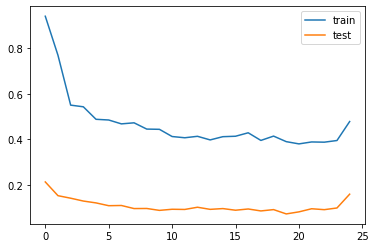

done | time taken: 461.312790 seconds
Test RMSE: 15.729
13.3617935
0.09597734311508288


In [17]:
rmses = []
maes = []
rsquared = []
times = []


from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

# load dataset
for x in range(8):
    t0 = time.time()

    dataset = read_csv('pollution1.csv', header=0, index_col=0)
    # dataset = dataset[2000:6000]
    # ensure all data is float
    values = dataset.values
    values = values.astype('float32')
    scaler = RobustScaler()
    scaled = scaler.fit_transform(values)
    n_hours = 8
    n_features = 6 # changed features from 5 to six
    reframed = series_to_supervised(scaled, n_hours, 8)
    print(reframed.shape)


    # split into train and test sets
    values = reframed.values
    n_train_hours = 3000
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X = train[:, :n_obs]
    train_y = train[:, -n_features]
    test_X = test[:, :n_obs]
    test_y = test[:, -n_features]

    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    n_out = 1
    #######


    # Building the model
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256,return_sequences=True, dropout=0.2, input_shape=(n_hours,n_features)))) # change number of neurons to 256, 128
    model.add(Bidirectional(LSTM(128, dropout=0.2)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False) # try combo


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat) #################
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    from sklearn.metrics import mean_absolute_error, r2_score

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -5:]), axis=1) # changed from -7 to -11 to -5 # because it is n_features-1. also had really good results for -11?
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = (mean_absolute_error(inv_y, inv_yhat))
    r2 = (r2_score(inv_y, inv_yhat))



    t1 = time.time()


    total = t1-t0

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    print("done | time taken: %f seconds" %total)
    print('Test RMSE: %.3f' % rmse)
    print(mae)
    print(r2)
    #print(mae)
    maes.append(mae)
    rmses.append(rmse)
    rsquared.append(r2)
    times.append(total)

In [18]:
mymae = [round(x, 2) for x in maes]
myrmse = [round(x, 2) for x in rmses]
myrsquared = [round(x, 2) for x in rsquared]
mytime = [round(x, 2) for x in times]

print(mymae)
print(myrmse)
print(myrsquared)
print(mytime)

[9.01, 10.65, 8.74, 7.73, 9.4, 8.37, 11.46, 13.36]
[11.11, 12.96, 10.92, 10.12, 11.62, 10.77, 13.74, 15.73]
[0.55, 0.39, 0.56, 0.63, 0.51, 0.58, 0.31, 0.1]
[542.59, 500.87, 632.39, 688.9, 351.07, 392.02, 500.54, 461.31]


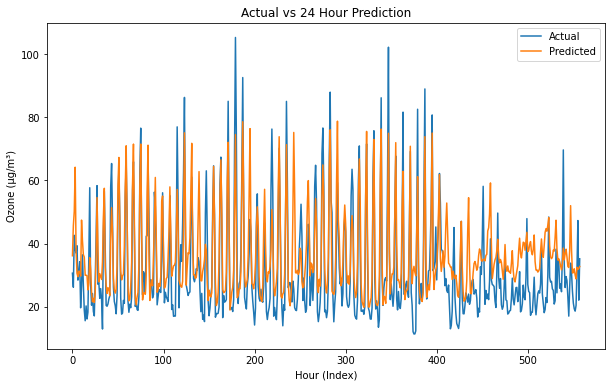

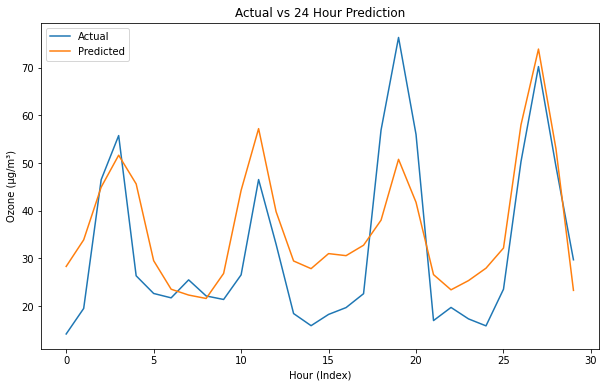

In [14]:
### plots

# entire thing

actual = inv_y
pred2 = inv_yhat
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

# sample

actual = inv_y[200:230]
pred2 = inv_yhat[200:230]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

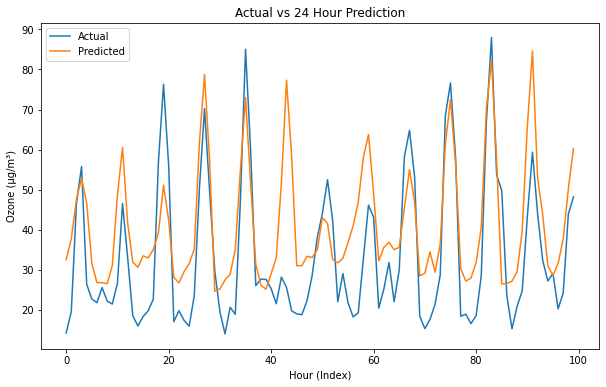

In [10]:
sample = (dataset['O3'][2200:2400])

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

In [ ]:
print('run test')